<a href="https://colab.research.google.com/github/tertiadecima/MachineLearning/blob/master/banks_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Алгоритм классификации тональности твита на данных соревнования SentiRuEval-2016**

Ниже выписаны мои наблюдения для твитов. Ниже произведена попытка их имплементировать.
* "повы вклад" дает +
* "повы ипотек" дает -
* "повы кредит" дает -
* "сни ипотек" дает +
* "сни кредит" дает +
* "санкц" дает -
* "города" дают 0
* конструкция "как (можно/легко) (взять/узнать/получить/оформить)" дает 0
* http://co. - idf высокий. значит надо исключить слова с оригинальной частью ссылки. 
* http и другие телеграм ссылки дают 0
* пунктуация, ники пользователей, стоп слова и цифры дают достаточно высокий idf, их исключаем, они не оказывают влияние на тональность

# Импорты

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from lxml import etree

In [3]:
from typing import List, Tuple

In [4]:
import string, re

In [5]:
%pip install spacy-udpipe

     |████████████████████████████████| 6.0 MB 5.2 MB/s 
     |████████████████████████████████| 304 kB 39.5 MB/s 
     |████████████████████████████████| 451 kB 47.7 MB/s 
     |████████████████████████████████| 181 kB 57.9 MB/s 
     |████████████████████████████████| 10.1 MB 40.2 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 628 kB 59.9 MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp37-cp37m-linux_x86_64.whl size=5626742 sha256=be01f26e1b76fcb6c0df3f397e376b1848d32e99793f6cd0e256036c881cc5d5
  Stored in directory: /root/.cache/pip/wheels/b8/b5/8e/3da091629a21ce2d10bf90759d0cb034ba10a5cf7a01e83d64
Successfully built ufal.udpipe
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successf

In [6]:
import spacy_udpipe

In [7]:
%pip install pymorphy2==0.8

     |████████████████████████████████| 46 kB 1.9 MB/s 
     |████████████████████████████████| 7.1 MB 11.8 MB/s 


In [8]:
spacy_udpipe.download("ru-syntagrus") 
nlp = spacy_udpipe.load("ru-syntagrus")

Downloaded pre-trained UDPipe model for 'ru-syntagrus' language




---

# Загрузка, лемматизация и очистка корпуса

In [9]:
def rubbish_deleter(s):
  lemmas = []
  for token in nlp(s):
    if token.is_stop or token.pos_=="X": # проверка на стоп слово
      pass
    else:
      lemmas.append(token.lemma_) # тут слова лемматизируются с помощью spacy
  s_lemmd = ' '.join(lemmas)                                                
  webs = '((?<=http:\/\/)t\.\S+\.?\S+[\s^\v]?)'
  nums = '(\d+[\s^\v]?)'
  names = '(@\S+)'
  re_webs = re.compile(webs)                                    # Ссылки
  re_names = re.compile(names)                                  # Ники
  re_pnct = re.compile('[%s]' % re.escape(string.punctuation))  # Пунктуация
  re_nums = re.compile(nums)                                    # Числа
  s_dewebbed = re_webs.sub(' ', s_lemmd)
  s_denamed = re_names.sub('', s_dewebbed)
  s_stripped = re_pnct.sub('', s_denamed)
  s_denummed = re_nums.sub('', s_stripped)
  
  return s_denummed

In [10]:
def load_sentirueval_2016(file_name: str) -> Tuple[List[str], List[str]]:
    texts = []
    labels = []
    with open(file_name, mode='rb') as fp:
        xml_data = fp.read()
    root = etree.fromstring(xml_data)
    for database in root.getchildren():
        if database.tag == 'database':
            for table in database.getchildren():
                if table.tag != 'table':
                    continue
                new_text = None
                new_label = None
                for column in table.getchildren():
                    if column.get('name') == 'text':
                        new_text = rubbish_deleter(column.text) # дополнено функцией тут
                        if new_label is not None:
                            break
                    elif column.get('name') not in {'id', 'twitid', 'date'}:
                        if new_label is None:
                            label_candidate = str(column.text).strip()
                            if label_candidate in {'0', '1', '-1'}:
                                new_label = 'negative' if label_candidate == '-1' else \
                                    ('positive' if label_candidate == '1' else 'neutral')
                                if new_text is not None:
                                    break
                if (new_text is None) or (new_label is None):
                    raise ValueError('File `{0}` contains some error!'.format(file_name))
                texts.append(new_text)
                labels.append(new_label)
            break
    return texts, labels

In [11]:
fXML_train = '/content/drive/My Drive/Colab Notebooks/bank_train_2016.xml'
fXML_test = '/content/drive/My Drive/Colab Notebooks/banks_test_etalon.xml'

In [12]:
texts, labels = load_sentirueval_2016(fXML_train)
texts_test, labels_test = load_sentirueval_2016(fXML_test)

In [13]:
print('Number of texts is {0}, number of labels is {1}.'.format(len(texts), len(labels)))

Number of texts is 9392, number of labels is 9392.




---

# Векторизация через Count

In [14]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True, tokenizer=word_tokenize) # создаем экземпляр класса CV

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
vectorizer.fit(texts) # вызываем функцию fit() для обучения словам

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


CountVectorizer(tokenizer=<function word_tokenize at 0x7f216beb0d40>)

In [17]:
print(vectorizer.get_feature_names()[0:20])

['a', 'ag', 'agrob', 'alfa', 'alfabank', 'alfaclick', 'aliexpress', 'amp', 'android', 'api', 'apple', 'appsall', 'appstore', 'at', 'autofollow', 'autofollowback', 'awards', 'bandicoot', 'bank', 'banki']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
print(len(vectorizer.get_feature_names()))

7312


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
X = vectorizer.transform(texts) # вызываем функцию transform() для кодирования твитов как векторов

In [20]:
print(type(X)) # получаем матрицу для дальнейшего использования

<class 'scipy.sparse.csr.csr_matrix'>


In [21]:
print(texts[0])

http брать кредит тюмень альфа банк


In [22]:
print(X[0]) # (номер предложения, номер слова) кол-во слова в предложении (вектор слова?)

  (0, 115)	1
  (0, 472)	1
  (0, 621)	1
  (0, 802)	1
  (0, 2753)	1
  (0, 6508)	1


In [23]:
print(vectorizer.get_feature_names()[6321])

телекарта


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)




---
# Векторизация через tf-id

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer # используем трансформер на матрице (после countvectorizer), vectorizer сам по себе 

In [25]:
transformer = TfidfTransformer().fit(X)

In [26]:
X_transformed = transformer.transform(X)

In [27]:
print(X_transformed[0]) # (предложение, номер слова) тф

  (0, 6508)	0.7538319201702378
  (0, 2753)	0.21446171098236816
  (0, 802)	0.39865906884440105
  (0, 621)	0.2425273277942924
  (0, 472)	0.3765414367390165
  (0, 115)	0.16189996656750633


In [28]:
print(X_transformed.shape) # (к-во предложений, к-во слов)

(9392, 7312)


In [29]:
print(vectorizer.get_feature_names()[7199])

электругой


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
# получаем список таплов (слово, его idf)
tokens_with_IDF = list(zip(vectorizer.get_feature_names(), transformer.idf_))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
for feature, idf in tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => a
9.049108 => ag
9.049108 => agrob
9.049108 => alfa
9.049108 => alfabank
9.049108 => alfaclick
9.454573 => aliexpress
8.355961 => amp
8.761426 => android
9.454573 => api
9.049108 => apple
9.454573 => appsall
9.454573 => appstore
9.454573 => at
9.049108 => autofollow
8.761426 => autofollowback
8.761426 => awards
9.049108 => bandicoot
9.049108 => bank
9.454573 => banki


In [32]:
sorted_tokens_with_IDF = sorted(tokens_with_IDF, key=lambda it: (-it[1], it[0]))

In [33]:
for feature, idf in sorted_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => a
9.454573 => aliexpress
9.454573 => api
9.454573 => appsall
9.454573 => appstore
9.454573 => at
9.454573 => banki
9.454573 => banking
9.454573 => bankvtbнадеяться
9.454573 => bitlydqeom
9.454573 => bitlydqxom
9.454573 => biznews
9.454573 => blatt
9.454573 => bump
9.454573 => callцентр
9.454573 => callцентра
9.454573 => camp
9.454573 => card
9.454573 => cash
9.454573 => chelyabinsk




---

# Разделяем тренировочную выборку на 80-20, занимаемся ее сортировкой

In [34]:
from sklearn.feature_selection import SelectPercentile, chi2

In [35]:
selector = SelectPercentile(chi2, percentile=20)

In [36]:
selector.fit(X_transformed, labels)

SelectPercentile(percentile=20, score_func=<function chi2 at 0x7f216b2f4200>)

In [37]:
selected_tokens_with_IDF = [tokens_with_IDF[idx] for idx in selector.get_support(indices=True)]

In [38]:
print(len(selected_tokens_with_IDF))

1463


покажем 20 features (признаков) из 20% отобранных методом Хи-квадрат (по алфавиту)

In [39]:
for feature, idf in selected_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.049108 => apple
9.454573 => appstore
9.049108 => autofollow
8.761426 => awards
8.538282 => boerse
9.049108 => brkng
9.049108 => cemitsvetiс
9.049108 => cgi
9.454573 => come
8.355961 => d
9.454573 => diabloiii
9.454573 => ekb
9.049108 => electron
9.049108 => ff
8.538282 => ffru
7.056678 => finance
7.439670 => fitch
8.355961 => followback
9.049108 => ft
7.845135 => ftse


In [40]:
selected_and_sorted_tokens_with_IDF = sorted(selected_tokens_with_IDF, key=lambda it: (-it[1], it[0]))

покажем 20 features (признаков) из 20% отобранных методом Хи-квадрат (по idf и по алфавиту) 

In [41]:
for feature, idf in selected_and_sorted_tokens_with_IDF[0:20]: print('{0:.6f} => {1}'.format(idf, feature))

9.454573 => appstore
9.454573 => come
9.454573 => diabloiii
9.454573 => ekb
9.454573 => hsbc
9.454573 => httpstcoiypfjojca
9.454573 => httpstcosutgdas
9.454573 => httpstcotyhbdxwx
9.454573 => iosандроид
9.454573 => london
9.454573 => lthttp
9.454573 => mobile
9.454573 => moneynews
9.454573 => nalexandrowa
9.454573 => play
9.454573 => plc
9.454573 => portal
9.454573 => rdx
9.454573 => rmo
9.454573 => sb


покажем 50 наименее важных features (признаков) из 20% отобранных методом Хи-квадрат (по idf и алфавиту)

In [42]:
for feature, idf in selected_and_sorted_tokens_with_IDF[-50:]: print('{0:.6f} => {1}'.format(idf, feature))

5.272523 => уралсиб
5.242445 => условие
5.206078 => банкомат
5.198960 => наличный
5.164113 => работа
5.117282 => миллиард
5.110767 => российский
5.091474 => автокредит
4.994428 => клиент
4.960334 => бизнес
4.938234 => ставка
4.911278 => новость
4.885030 => райффайзенбанк
4.864516 => калькулятор
4.815001 => деньги
4.810182 => ипотечный
4.791134 => ипотека
4.772442 => попасть
4.740548 => получить
4.700983 => оформить
4.688134 => …
4.650552 => список
4.646462 => рубль
4.622267 => ввести
4.606456 => заявка
4.571771 => против
4.527319 => новый
4.488238 => под
4.414379 => год
4.398327 => ес
4.339578 => сша
4.286934 => потребительский
4.247823 => онлайн
4.212826 => газпромбанк
4.210184 => »
4.189295 => «
3.814440 => rt
3.708370 => брать
3.633007 => кредитный
3.619762 => сбербанок
3.595212 => санкция
3.502629 => альфа
3.496148 => вт
3.476954 => москва
3.329889 => карта
3.293366 => россельхозбанк
3.146474 => втб
2.256015 => банк
1.994946 => кредит
1.506011 => http




---


# Logistic Regression (без поиска)


In [43]:
import time

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
cls = LogisticRegression(solver='liblinear', verbose=True)

In [46]:
X_transformed_and_selected = selector.transform(X_transformed)
cls.fit(X_transformed_and_selected, labels)

[LibLinear]

LogisticRegression(solver='liblinear', verbose=True)

In [47]:
classes_list = list(cls.classes_)
print(classes_list)

['negative', 'neutral', 'positive']


In [48]:
# удаляем нейтральные твиты для последующего рассчёта F1-меры
texts_for_testing = [texts_test[i] for i in range(len(texts_test)) if labels_test[i] != 'neutral']
labels_for_testing = [l for l in labels_test if l != 'neutral']

In [49]:
from sklearn.pipeline import Pipeline

In [50]:
pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', cls)
    ]
)

In [51]:
from sklearn.metrics import roc_curve
import numpy as np

In [52]:
probabilities = pipeline_for_se.predict_proba(texts_for_testing)

In [53]:
y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]

In [54]:
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

In [55]:
y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

In [56]:
# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

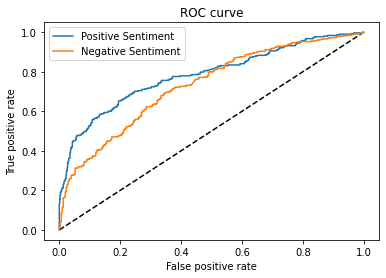

In [57]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [58]:
from sklearn.metrics import f1_score
predicted_labels = pipeline_for_se.predict(texts_for_testing)
print('F1-micro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='micro')))
print('F1-macro = {0:.6f}'.format(f1_score(labels_for_testing, predicted_labels, average='macro')))

F1-micro = 0.284651
F1-macro = 0.265223


In [59]:
from sklearn.metrics import classification_report
print(classification_report(labels_for_testing, predicted_labels, digits=6))

              precision    recall  f1-score   support

    negative   0.904059  0.319426  0.472062       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.884058  0.198052  0.323607       308

    accuracy                       0.284651      1075
   macro avg   0.596039  0.172493  0.265223      1075
weighted avg   0.898329  0.284651  0.429528      1075



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# gCV + LogRegr

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
f1_macro_scorer = make_scorer(f1_score, average='macro')
gcv_lr = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={'C': [1e-2, 1e-1, 1, 1e+1, 1e+2, 1e+3], 'penalty': ['l1', 'l2', 'elasticnet']},
    scoring=f1_macro_scorer,
    n_jobs=-1,
)

In [61]:
gcv_lr_tp1 = time.time()
gcv_lr.fit(X_transformed_and_selected, labels)
gcv_lr_tp2 = time.time()
print(f'Time needed for search: {gcv_lr_tp2 - gcv_lr_tp1}s')

Time needed for search: 6.260038137435913s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 459, in _check_solver
    solver
ValueError: Only 'saga' solver 

In [62]:
gcv_lr_bp = gcv_lr.best_params_
print(gcv_lr_bp)

{'C': 100.0, 'penalty': 'l2'}


In [63]:
bcls_gcv_lr = LogisticRegression(
                                 solver='liblinear', 
                                 verbose=True, 
                                 C=gcv_lr_bp['C'], 
                                 penalty=gcv_lr_bp['penalty']
                                )

In [64]:
gcv_lr_tp3 = time.time()
bcls_gcv_lr.fit(X_transformed_and_selected, labels)
gcv_lr_tp4 = time.time()
print(f'Time needed for computation: {gcv_lr_tp4 - gcv_lr_tp3}s')

[LibLinear]Time needed for computation: 0.16365718841552734s


In [65]:
best_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', bcls_gcv_lr)
    ]
)

In [66]:
probabilities = best_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

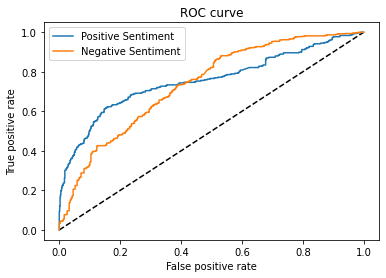

In [67]:
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [68]:
predicted_labels = best_pipeline_for_se.predict(texts_for_testing)
fmi_gcv_lr = f1_score(labels_for_testing, predicted_labels, average='micro')
fma_gcv_lr = f1_score(labels_for_testing, predicted_labels, average='macro')
print('F1-micro = {0:.6f}'.format(fmi_gcv_lr))
print('F1-macro = {0:.6f}'.format(fma_gcv_lr))

F1-micro = 0.458605
F1-macro = 0.370266


In [69]:
clsrep_gcv_lr = classification_report(labels_for_testing, predicted_labels, digits=6)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
print(clsrep_gcv_lr)

              precision    recall  f1-score   support

    negative   0.843478  0.505867  0.632437       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.801527  0.340909  0.478360       308

    accuracy                       0.458605      1075
   macro avg   0.548335  0.282259  0.370266      1075
weighted avg   0.831459  0.458605  0.588292      1075



# gCV + SGDC 

In [71]:
from sklearn.linear_model import SGDClassifier

In [83]:
gcv_sgdc = GridSearchCV(
    estimator=SGDClassifier(loss='log'),
    param_grid={
                'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1], 
                'penalty': ['l1', 'l2', 'elasticnet']
                },
    scoring=f1_macro_scorer,
    n_jobs=-1
)

In [84]:
gcv_sgdc_tp1 = time.time()
gcv_sgdc.fit(X_transformed_and_selected, labels)
gcv_sgdc_tp2 = time.time()

In [85]:
print(f'Time needed for search: {gcv_sgdc_tp2 - gcv_sgdc_tp1}s')
gcv_sgdc_bp = gcv_sgdc.best_params_
print(gcv_sgdc_bp)

Time needed for search: 4.006702661514282s
{'alpha': 0.0001, 'penalty': 'l1'}


In [86]:
bcls_gcv_sgdc = SGDClassifier( 
                     loss='log',
                     penalty=gcv_sgdc_bp['penalty'],
                     alpha=gcv_sgdc_bp['alpha'],
                     max_iter=1000
                    )

In [87]:
gcv_sgdc_tp3 = time.time()
bcls_gcv_sgdc.fit(X_transformed_and_selected, labels)
gcv_sgdc_tp4 = time.time()

In [89]:
print(f'Time needed for computations: {gcv_sgdc_tp4 - gcv_sgdc_tp3}s')

Time needed for computations: 0.09301304817199707s


In [88]:
sgdc_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', bcls_gcv_sgdc)
    ]
)

In [90]:
probabilities = sgdc_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

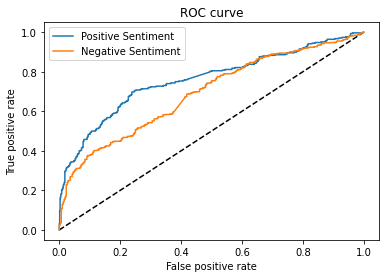

In [91]:
plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [92]:
predicted_labels = sgdc_pipeline_for_se.predict(texts_for_testing)
fmi_gcv_sgdc = f1_score(labels_for_testing, predicted_labels, average='micro')
fma_gcv_sgdc = f1_score(labels_for_testing, predicted_labels, average='macro')
print('F1-micro = {0:.6f}'.format(fmi_gcv_sgdc))
print('F1-macro = {0:.6f}'.format(fma_gcv_sgdc))

F1-micro = 0.315349
F1-macro = 0.294059


In [93]:
clsrep_gcv_sgdc = classification_report(labels_for_testing, predicted_labels, digits=6)
print(clsrep_gcv_sgdc)

              precision    recall  f1-score   support

    negative   0.906574  0.341591  0.496212       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.846154  0.250000  0.385965       308

    accuracy                       0.315349      1075
   macro avg   0.584243  0.197197  0.294059      1075
weighted avg   0.889263  0.315349  0.464625      1075



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# bCV + LogRegr

In [94]:
%pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

     |████████████████████████████████| 100 kB 3.6 MB/s 


In [95]:
bcv_lr = BayesSearchCV(
    LogisticRegression(solver='liblinear'), 
    { 
    'penalty': ['l1','l2'],
    'C': (1, 100, 'log-uniform'),
    'fit_intercept': [True, False]
},
    n_iter = 32,
    scoring=f1_macro_scorer,
    random_state=0
)


In [96]:
bcv_lr_tp1 = time.time()
bcv_lr.fit(X_transformed_and_selected, labels)
bcv_lr_tp2 = time.time()

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [97]:
print(f'Time needed for search: {bcv_lr_tp2 - bcv_lr_tp1}s')
bcv_lr_bp = bcv_lr.best_params_
print(bcv_lr_bp)

Time needed for search: 51.99661087989807s
OrderedDict([('C', 75), ('fit_intercept', True), ('penalty', 'l2')])


In [98]:
bcls_bcv_lr = LogisticRegression(
                                 solver='liblinear', 
                                 verbose=True, 
                                 C=bcv_lr_bp['C'], 
                                 penalty=bcv_lr_bp['penalty']
                                 )
bcv_lr_tp3 = time.time()
bcls_bcv_lr.fit(X_transformed_and_selected, labels)
bcv_lr_tp4 = time.time()
print('Time needed for computations: ', bcv_lr_tp4 - bcv_lr_tp3)

[LibLinear]Time needed for computations:  0.15207529067993164


In [99]:
rand_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', bcls_bcv_lr)
    ]
)

In [100]:
probabilities = rand_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

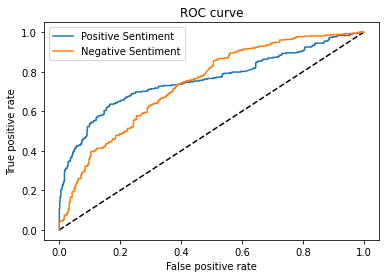

In [101]:
plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [102]:
predicted_labels = rand_pipeline_for_se.predict(texts_for_testing)
fmi_bcv_lr = f1_score(labels_for_testing, predicted_labels, average='micro')
fma_bcv_lr = f1_score(labels_for_testing, predicted_labels, average='macro')
print('F1-micro = {0:.6f}'.format(fmi_bcv_lr))
print('F1-macro = {0:.6f}'.format(fma_bcv_lr))

F1-micro = 0.461395
F1-macro = 0.371124


In [103]:
clsrep_bcv_lr = classification_report(labels_for_testing, predicted_labels, digits=6)
print(clsrep_bcv_lr)

              precision    recall  f1-score   support

    negative   0.846652  0.511082  0.637398       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.806202  0.337662  0.475973       308

    accuracy                       0.461395      1075
   macro avg   0.550951  0.282915  0.371124      1075
weighted avg   0.835063  0.461395  0.591148      1075



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# bCV + SGDC

In [104]:
from sklearn.linear_model import SGDClassifier

In [105]:
bcv_sgdc = BayesSearchCV(
    SGDClassifier(loss='log'),
    {
                'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1], 
                'penalty': ['l1', 'l2', 'elasticnet']
                },
    n_iter = 100,
    scoring=f1_macro_scorer
)

In [106]:
bcv_sgdc_tp1 = time.time()
bcv_sgdc.fit(X_transformed_and_selected, labels)
bcv_sgdc_tp2 = time.time()

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

In [107]:
print(f'Time needed for search: {bcv_sgdc_tp2 - bcv_sgdc_tp1}s')
bcv_sgdc_bp = bcv_sgdc.best_params_
print(bcv_sgdc_bp)

Time needed for search: 273.56990456581116s
OrderedDict([('alpha', 0.0001), ('penalty', 'l1')])


In [108]:
bcls_bcv_sgdc = SGDClassifier( 
                     loss='log',
                     penalty=bcv_sgdc_bp['penalty'],
                     alpha=bcv_sgdc_bp['alpha'],
                     max_iter=1000
                    )

In [109]:
bcv_sgdc_tp3 = time.time()
bcls_bcv_sgdc.fit(X_transformed_and_selected, labels)
bcv_sgdc_tp4 = time.time()

In [110]:
print(f'Time needed for computations: {bcv_sgdc_tp4 - bcv_sgdc_tp3}s')

Time needed for computations: 0.06177949905395508s


In [111]:
sgdc_pipeline_for_se = Pipeline(
    [
        ('vectorizer', vectorizer),
        ('tfidf', transformer),
        ('selector', selector),
        ('final_classifier', bcls_bcv_sgdc)
    ]
)

In [112]:
probabilities = sgdc_pipeline_for_se.predict_proba(texts_for_testing)

y_true_positives = list(map(lambda it: 1 if it == 'positive' else 0, labels_for_testing))
y_score_positives = probabilities[:, classes_list.index('positive')]
fpr_positives, tpr_positives, _, = roc_curve(y_true_positives, y_score_positives)

y_true_negatives = list(map(lambda it: 1 if it == 'negative' else 0, labels_for_testing))
y_score_negatives = probabilities[:, classes_list.index('negative')]
fpr_negatives, tpr_negatives, _, = roc_curve(y_true_negatives, y_score_negatives)

# y_true_neutrals = list(map(lambda it: 1 if it == 'neutral' else 0, labels_for_testing))
# y_score_neutrals = probabilities[:, classes_list.index('neutral')]
# fpr_neutrals, tpr_neutrals, _, = roc_curve(y_true_neutrals, y_score_neutrals)

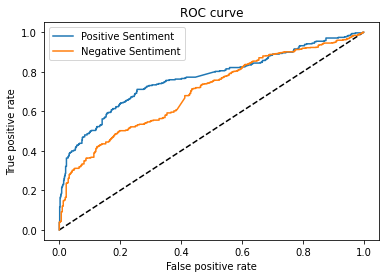

In [113]:
plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_positives, tpr_positives, label='Positive Sentiment')
plt.plot(fpr_negatives, tpr_negatives, label='Negative Sentiment')
# plt.plot(fpr_neutrals, tpr_neutrals, label='Neutral Sentiment')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [114]:
predicted_labels = sgdc_pipeline_for_se.predict(texts_for_testing)
fmi_bcv_sgdc = f1_score(labels_for_testing, predicted_labels, average='micro')
fma_bcv_sgdc = f1_score(labels_for_testing, predicted_labels, average='macro')
print('F1-micro = {0:.6f}'.format(fmi_bcv_sgdc))
print('F1-macro = {0:.6f}'.format(fma_bcv_sgdc))

F1-micro = 0.320000
F1-macro = 0.302740


In [115]:
clsrep_bcv_sgdc = classification_report(labels_for_testing, predicted_labels, digits=6)
print(clsrep_bcv_sgdc)

              precision    recall  f1-score   support

    negative   0.896194  0.337679  0.490530       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.858586  0.275974  0.417690       308

    accuracy                       0.320000      1075
   macro avg   0.584927  0.204551  0.302740      1075
weighted avg   0.885419  0.320000  0.469661      1075



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Выводы

In [116]:
scheme = '--- {}\nSearch time: {}\nComputation time: {}\nF1-micro = {}\nF1-macro = {}\nReport:\n{}\n' 
print(scheme.format('gCV + LogReg', gcv_lr_tp2-gcv_lr_tp1, gcv_lr_tp4-gcv_lr_tp3, fmi_gcv_lr, fma_gcv_lr, clsrep_gcv_lr))
print(scheme.format('gCV + SGDC', gcv_sgdc_tp2-gcv_sgdc_tp1, gcv_sgdc_tp4-gcv_sgdc_tp3, fmi_gcv_sgdc, fma_gcv_sgdc, clsrep_gcv_sgdc))
print(scheme.format('bCV + LogReg', bcv_lr_tp2-bcv_lr_tp1, bcv_lr_tp4-bcv_lr_tp3, fmi_bcv_lr, fma_bcv_lr, clsrep_bcv_lr))
print(scheme.format('bCV + SGDC', bcv_sgdc_tp2-bcv_sgdc_tp1, bcv_sgdc_tp4-bcv_sgdc_tp3, fmi_bcv_sgdc, fma_bcv_sgdc, clsrep_bcv_sgdc))

--- gCV + LogReg
Search time: 6.260038137435913
Computation time: 0.16365718841552734
F1-micro = 0.45860465116279064
F1-macro = 0.3702655822332126
Report:
              precision    recall  f1-score   support

    negative   0.843478  0.505867  0.632437       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.801527  0.340909  0.478360       308

    accuracy                       0.458605      1075
   macro avg   0.548335  0.282259  0.370266      1075
weighted avg   0.831459  0.458605  0.588292      1075


--- gCV + SGDC
Search time: 4.006702661514282
Computation time: 0.09301304817199707
F1-micro = 0.31534883720930235
F1-macro = 0.2940590111642743
Report:
              precision    recall  f1-score   support

    negative   0.906574  0.341591  0.496212       767
     neutral   0.000000  0.000000  0.000000         0
    positive   0.846154  0.250000  0.385965       308

    accuracy                       0.315349      1075
   macro avg   0.584243  0.197197  0.2

~ Выводы ~
По полученным результататм выходит, что
- регрессия всегда лучше SGDC
- качественной разницы между алгоритмами перебора (сетка и байес) нет
- по времени выигрывает перебор по сетке